# Basic ML example (Prefect Workflow)

Here, we use the PrefectWorkflow backend for the Basic ML example. Again, we reimplement sklearn [example](https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html#sphx-glr-auto-examples-linear-model-plot-sparse-logistic-regression-mnist-py) as Function Fuse workflow, using identical frontend workflow definition as in the LocalWorkflow and RayWorkflow examples, but providing Prefect-specific options in the backend.

We can optionally activate a Prefect server to view information about workflow runs in a browser:

```console
$ prefect server start
```

## The workflow

In [6]:
from functionfuse import workflow
from functionfuse.backends.addons.prefectback import PrefectWorkflow
from functionfuse.storage import storage_factory

import os


# Frontend

@workflow
def openml_dataset():
    from sklearn.datasets import fetch_openml
    from sklearn.utils import check_random_state

    X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas")
    random_state = check_random_state(0)
    permutation = random_state.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    X = X.reshape((X.shape[0], -1))
    return X, y


@workflow
def train_test_split(X, y, train_samples, test_size):
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_samples, test_size=test_size
    )
    return {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}

@workflow
def train_model(X, y):
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import make_pipeline
    from sklearn.linear_model import LogisticRegression

    train_samples = len(X)
    clf = make_pipeline(StandardScaler(), LogisticRegression(C=50.0 / train_samples, penalty="l1", solver="saga", tol=0.1))
    clf.fit(X, y)
    return clf


dataset = openml_dataset().set_name("dataset")
X, y = dataset[0], dataset[1]
dataset_split = train_test_split(X, y, train_samples = 5000, test_size = 10000).set_name("dataset_split")
model = train_model(dataset_split["X_train"], dataset_split["y_train"]).set_name("model")


# Prefect Backend

# Example of specifying a task_runner
from prefect.task_runners import SequentialTaskRunner, ConcurrentTaskRunner
prefect_flow_args = {
    "description": "Basic ML workflow from sklearn",
    "task_runner": ConcurrentTaskRunner()
}

prefect_workflow = PrefectWorkflow(dataset, workflow_name="classifier")
opt = {
    "kind": "file",
    "options": {
        "path": "storage"
    }
}
storage = storage_factory(opt)
# prefect_workflow.set_storage(storage)

# Example of setting Prefect Task options for a specific Node
from prefect.tasks import task_input_hash
prefect_workflow.query(pattern="^model$").set_task_args({"cache_key_fn": task_input_hash})

# Optionally create the Prefect Flow prior to running:
prefect_workflow.generate_flow()
print(type(prefect_workflow.flow))

<class 'prefect.flows.Flow'>


/home/hm/miniconda3/envs/pytorch_cuda/lib/python3.10/site-packages/prefect/flows.py:244: UserWarning: A flow named 'classifier' and defined at '/home/hm/CardiacFilament/functionfuse/functionfuse/backends/addons/prefectback.py:134' conflicts with another flow. Consider specifying a unique `name` parameter in the flow definition:

 `@flow(name='my_unique_name', ...)`
  warnings.warn(


In [7]:
_ = prefect_workflow.run()

16:58:07.160 | INFO    | prefect.engine - Created flow run 'fortunate-stingray' for flow 'classifier'

/home/hm/miniconda3/envs/pytorch_cuda/lib/python3.10/site-packages/prefect/tasks.py:298: UserWarning: A task named 'openml_dataset' and defined at '/tmp/ipykernel_10727/1591802011.py:10' conflicts with another task. Consider specifying a unique `name` parameter in the task definition:

 `@task(name='my_unique_name', ...)`
  warnings.warn(


16:58:07.293 | INFO    | Flow run 'fortunate-stingray' - Created task run 'openml_dataset-0' for task 'openml_dataset'

16:58:07.296 | INFO    | Flow run 'fortunate-stingray' - Executing 'openml_dataset-0' immediately...

16:58:16.453 | INFO    | Task run 'openml_dataset-0' - Finished in state Completed()

/home/hm/miniconda3/envs/pytorch_cuda/lib/python3.10/site-packages/prefect/tasks.py:298: UserWarning: A task named 'train_test_split' and defined at '/tmp/ipykernel_10727/1591802011.py:24' conflicts with another task. Consider specifying a unique `name` parameter in the task definition:

 `@task(name='my_unique_name', ...)`
  warnings.warn(


16:58:16.486 | INFO    | Flow run 'fortunate-stingray' - Created task run 'train_test_split-0' for task 'train_test_split'

16:58:16.488 | INFO    | Flow run 'fortunate-stingray' - Executing 'train_test_split-0' immediately...

16:58:16.614 | INFO    | Task run 'train_test_split-0' - Finished in state Completed()

/home/hm/miniconda3/envs/pytorch_cuda/lib/python3.10/site-packages/prefect/tasks.py:298: UserWarning: A task named 'train_model' and defined at '/tmp/ipykernel_10727/1591802011.py:33' conflicts with another task. Consider specifying a unique `name` parameter in the task definition:

 `@task(name='my_unique_name', ...)`
  warnings.warn(


16:58:16.645 | INFO    | Flow run 'fortunate-stingray' - Created task run 'train_model-0' for task 'train_model'

16:58:16.647 | INFO    | Flow run 'fortunate-stingray' - Executing 'train_model-0' immediately...

16:58:19.180 | INFO    | Task run 'train_model-0' - Finished in state Completed()

16:58:19.215 | INFO    | Flow run 'fortunate-stingray' - Finished in state Completed()

## Prefect Server

A Prefect Flow is created within the functionfuse Workflow, and the Flow Run is 
logged to the Prefect Server. The Flow name matches the workflow name. Each 
Node in the functionfuse Workflow becomes a Prefect Task with a name matching
the Node.func name.

![Flow Run in Prefect Server](images/PrefectServerBasicML.png)

## Model Prediction

The code above is designed to train models and save the workflow data in the storage. Typically this code should be placed in a separate Python module. I placed the workflow code in the Jupyter Notebook for demonstration purposes only. Final model analysis and data visualization are performed from the stored data in the Jupyter Notebook as shown below.

In [3]:
import pprint
from functionfuse.storage import storage_factory

the_workflow_name = "classifier"
storage_path = "storage"
opt = {
    "kind": "file",
    "options": {
        "path": storage_path
    }
}
storage = storage_factory(opt)
all_tasks = storage.list_tasks(workflow_name=the_workflow_name, pattern="*")

pp = pprint.PrettyPrinter(width=141, compact=True)
print("All graph node names: ")
pp.pprint(all_tasks)

All graph node names: 
['dataset', 'dataset_split', 'model']


Sparsity with L1 penalty: 80.24%
Test score with L1 penalty: 0.8349


Text(0.5, 0.98, 'Classification vector for...')

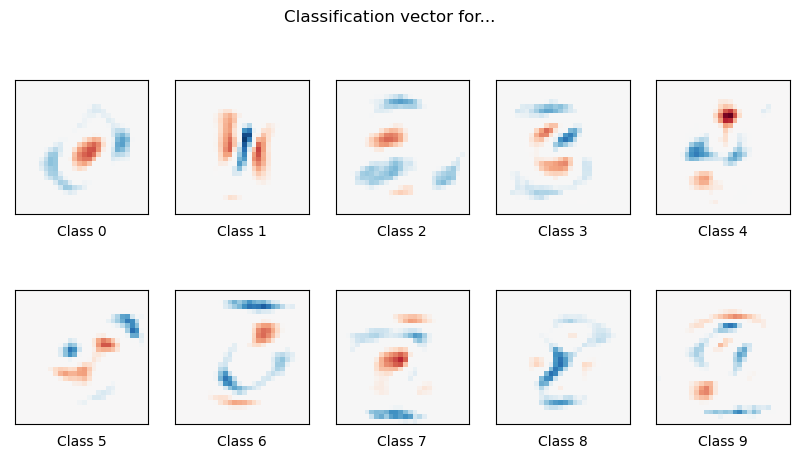

In [4]:
import numpy as np
import matplotlib.pyplot as plt

clf = storage.read_task(workflow_name=the_workflow_name, task_name="model")
dataset_split = storage.read_task(workflow_name=the_workflow_name,  task_name="dataset_split")
X_test, y_test = dataset_split["X_test"], dataset_split["y_test"]

lr = clf.named_steps["logisticregression"]

sparsity = np.mean(lr.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)
 


coef = lr.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(
        coef[i].reshape(28, 28),
        interpolation="nearest",
        cmap=plt.cm.RdBu,
        vmin=-scale,
        vmax=scale,
    )
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Class %i" % i)
plt.suptitle("Classification vector for...")